# Using Google Maps: Predicting Crime Pattern in San Francisco? Let's Predict and Map It on Google Cloud



In [1]:
import numpy as np 
import pandas as pd
import datetime
import urllib
import matplotlib.pyplot as plt
import calendar

# SF Crime Heat Map 
### https://data.sfgov.org/Public-Safety/SF-Crime-Heat-Map/q6gg-sa2p/data

In [2]:
# Get crime data and save a local copy, the first time around, then set the
# already_have_the_data flag to False to download the local copy as it is 
# a large file and can be very slow to download!
already_have_the_data = True
if not already_have_the_data:
    # downloading directly from the internet
    crime_df_raw = pd.read_csv('https://data.sfgov.org/api/views/q6gg-sa2p/rows.csv?accessType=DOWNLOAD')
    crime_df_raw.to_csv('/Users/namankumar/Downloads/sf-crime-horizon.csv', index=False)
else:
    # get crime data - save a local copy as it is a lot of data
    crime_df_raw = pd.read_csv('/Users/namankumar/Downloads/sf-crime-horizon.csv')
    
pd.set_option('display.max_columns', None)


In [3]:
crime_df_raw

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,4133422003074,41334220,3074,ROBBERY,"ROBBERY, BODILY FORCE",Monday,11/22/2004,17:50,INGLESIDE,NONE,GENEVA AV / SANTOS ST,-122.420084,37.708311,POINT (-122.420084075249 37.7083109744362),NaN,NaN,9.0,NaN,NaN,NaN,8.0,309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5118535807021,51185358,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,10/18/2005,20:00,PARK,NONE,TURK ST / STJOSEPHS AV,-120.500000,90.000000,POINT (-120.50000000000001 90),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4018830907021,40188309,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/15/2004,02:00,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.500000,90.000000,POINT (-120.50000000000001 90),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11014543126030,110145431,26030,ARSON,ARSON,Friday,02/18/2011,05:27,INGLESIDE,NONE,0 Block of SANJUAN AV,-122.436220,37.724377,POINT (-122.43622001281001 37.7243766140428),94.0,9.0,1.0,28.0,9.0,7.0,6.0,28861.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,94.0
4,10108108004134,101081080,4134,ASSAULT,BATTERY,Sunday,11/21/2010,17:00,SOUTHERN,NONE,400 Block of 10TH ST,-122.410541,37.770913,POINT (-122.410541166987 37.7709130566165),32.0,1.0,10.0,34.0,8.0,2.0,9.0,28853.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,16710,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Thursday,06/22/2017,01:42,CENTRAL,"ARREST, CITED",BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866),77.0,6.0,3.0,8.0,3.0,1.0,10.0,28860.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,77.0
2129521,17071435504014,170714355,4014,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,09/01/2017,17:00,PARK,NONE,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389),112.0,7.0,5.0,3.0,15.0,5.0,5.0,29492.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,112.0
2129522,17053348465010,170533484,65010,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,06/30/2017,17:50,BAYVIEW,"ARREST, BOOKED",ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817),56.0,2.0,9.0,26.0,10.0,3.0,8.0,28856.0,29.0,NaN,NaN,NaN,NaN,22.0,NaN,1.0,NaN,NaN,NaN,NaN,56.0
2129523,17102776330130,171027763,30130,OTHER OFFENSES,PEDDLING WITHOUT A LICENSE,Wednesday,12/20/2017,15:41,SOUTHERN,"ARREST, BOOKED",7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081),21.0,5.0,10.0,34.0,8.0,2.0,9.0,28853.0,34.0,3.0,1.0,3.0,1.0,3.0,7.0,2.0,1.0,1.0,1.0,35.0,21.0


In [4]:
crime_df = crime_df_raw.copy()
list(crime_df)

['PdId',
 'IncidntNum',
 'Incident Code',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'location',
 'SF Find Neighborhoods 2 2',
 'Current Police Districts 2 2',
 'Current Supervisor Districts 2 2',
 'Analysis Neighborhoods 2 2',
 'DELETE - Fire Prevention Districts 2 2',
 'DELETE - Police Districts 2 2',
 'DELETE - Supervisor Districts 2 2',
 'DELETE - Zip Codes 2 2',
 'DELETE - Neighborhoods 2 2',
 'DELETE - 2017 Fix It Zones 2 2',
 'Civic Center Harm Reduction Project Boundary 2 2',
 'Fix It Zones as of 2017-11-06  2 2',
 'DELETE - HSOC Zones 2 2',
 'Fix It Zones as of 2018-02-07 2 2',
 'CBD, BID and GBD Boundaries as of 2017 2 2',
 'Areas of Vulnerability, 2016 2 2',
 'Central Market/Tenderloin Boundary 2 2',
 'Central Market/Tenderloin Boundary Polygon - Updated 2 2',
 'HSOC Zones as of 2018-06-05 2 2',
 'OWED Public Spaces 2 2',
 'Neighborhoods 2']

In [5]:
crime_df.shape

(2129525, 35)

In [6]:
years = [int(dte.split("/")[2]) for dte in crime_df['Date']]
print('Max year %i, min year %i' % (max(years), min(years)))

Max year 2018, min year 2003


# Data Cleaning
* Identify the KPI's and the most relevant columns required to make analysis on the dataset.
* Tackle any null values or missing values on the dataset.
    - Remove/Delete those values using **dropna()** function.
    - Fill the null values with an appropriate and a meaningful value using **fillna()** or **replace()** method
* Remove unwanted columns and keep only the columns required for Data analysis.





In [7]:
## Listing Out the Null Values in the dataset
crime_df.isnull()

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,True,True,True,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129520,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,True,True,True,True,False
2129521,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,True,True,True,True,False
2129522,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,True,False,True,True,True,True,False
2129523,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
## Finding total number of Null Values in each Column
crime_df.isnull().sum()

PdId                                                              0
IncidntNum                                                        0
Incident Code                                                     0
Category                                                          0
Descript                                                          0
DayOfWeek                                                         0
Date                                                              0
Time                                                              0
PdDistrict                                                        1
Resolution                                                        0
Address                                                           0
X                                                                 0
Y                                                                 0
location                                                          0
SF Find Neighborhoods 2 2                       

In [9]:
# Finding total number of cells with null values in the dataset
crime_df.isnull().sum().sum()

17090273

In [10]:
crime_df['PdDistrict'].value_counts()

PdDistrict
SOUTHERN      390692
MISSION       288985
NORTHERN      266435
CENTRAL       221923
BAYVIEW       205480
TENDERLOIN    186954
INGLESIDE     181092
TARAVAL       155461
PARK          119698
RICHMOND      112804
Name: count, dtype: int64

In [11]:
#Filling the PdDistrict NaN value with the Most occuring value in the column.
crime_df.fillna({'PdDistrict': 'SOUTHERN'},inplace=True)

In [12]:
crime_df.isnull().sum()

PdId                                                              0
IncidntNum                                                        0
Incident Code                                                     0
Category                                                          0
Descript                                                          0
DayOfWeek                                                         0
Date                                                              0
Time                                                              0
PdDistrict                                                        0
Resolution                                                        0
Address                                                           0
X                                                                 0
Y                                                                 0
location                                                          0
SF Find Neighborhoods 2 2                       

In [13]:
#Dropping all columns with Null values as they are not a part of the dataset
crime_df = crime_df.dropna(axis=1)

In [14]:
crime_df

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location
0,4133422003074,41334220,3074,ROBBERY,"ROBBERY, BODILY FORCE",Monday,11/22/2004,17:50,INGLESIDE,NONE,GENEVA AV / SANTOS ST,-122.420084,37.708311,POINT (-122.420084075249 37.7083109744362)
1,5118535807021,51185358,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,10/18/2005,20:00,PARK,NONE,TURK ST / STJOSEPHS AV,-120.500000,90.000000,POINT (-120.50000000000001 90)
2,4018830907021,40188309,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/15/2004,02:00,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.500000,90.000000,POINT (-120.50000000000001 90)
3,11014543126030,110145431,26030,ARSON,ARSON,Friday,02/18/2011,05:27,INGLESIDE,NONE,0 Block of SANJUAN AV,-122.436220,37.724377,POINT (-122.43622001281001 37.7243766140428)
4,10108108004134,101081080,4134,ASSAULT,BATTERY,Sunday,11/21/2010,17:00,SOUTHERN,NONE,400 Block of 10TH ST,-122.410541,37.770913,POINT (-122.410541166987 37.7709130566165)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,16710,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Thursday,06/22/2017,01:42,CENTRAL,"ARREST, CITED",BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866)
2129521,17071435504014,170714355,4014,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,09/01/2017,17:00,PARK,NONE,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389)
2129522,17053348465010,170533484,65010,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,06/30/2017,17:50,BAYVIEW,"ARREST, BOOKED",ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817)
2129523,17102776330130,171027763,30130,OTHER OFFENSES,PEDDLING WITHOUT A LICENSE,Wednesday,12/20/2017,15:41,SOUTHERN,"ARREST, BOOKED",7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081)


In [15]:
#Ensuring that there are no null values left in the dataset
crime_df.isnull().sum()

PdId             0
IncidntNum       0
Incident Code    0
Category         0
Descript         0
DayOfWeek        0
Date             0
Time             0
PdDistrict       0
Resolution       0
Address          0
X                0
Y                0
location         0
dtype: int64

### After Careful inspection and Inspection we have identified the KPI's that are most useful for further analysis.

In [16]:
crime_df = crime_df[['Category', 'DayOfWeek', 'Date', 'Time', 'X', 'Y']]

# Rename X,Y to Longitude, Latitude
crime_df.columns = ['Category', 'DayOfWeek', 'Date', 'Time', 'Longitude', 'Latitude']
crime_df.head(10)

,Category,DayOfWeek,Date,Time,Longitude,Latitude
0,ROBBERY,Monday,11/22/2004,17:50,-122.420084,37.708311
1,VEHICLE THEFT,Tuesday,10/18/2005,20:00,-120.500000,90.000000
2,VEHICLE THEFT,Sunday,02/15/2004,02:00,-120.500000,90.000000
3,ARSON,Friday,02/18/2011,05:27,-122.436220,37.724377
4,ASSAULT,Sunday,11/21/2010,17:00,-122.410541,37.770913
5,ASSAULT,Tuesday,04/02/2013,15:50,-122.470366,37.745158
6,ASSAULT,Sunday,08/06/2017,18:15,-122.403405,37.775421
7,VEHICLE THEFT,Thursday,03/03/2016,19:30,-122.463545,37.707968
8,ASSAULT,Saturday,06/17/2006,03:00,-122.459173,37.708200
9,TRESPASS,Monday,11/28/2005,16:04,-120.500000,90.000000


# Data Exploration
###  Next step is to describe dataset characterizations, such as size, quantity, and accuracy, in order to better understand the nature of the data using data visualization and statistical techniques.

### Finding any Duplicate records that might be present in the dataset

In [18]:
crime_df.loc[crime_df.duplicated(keep='first'),:]

,Category,DayOfWeek,Date,Time,Longitude,Latitude
537,VEHICLE THEFT,Sunday,02/15/2004,02:00,-120.500000,90.000000
6178,VEHICLE THEFT,Saturday,04/10/2004,19:00,-122.401068,37.760364
8364,DRUG/NARCOTIC,Friday,01/05/2007,21:36,-122.408015,37.796700
10113,OTHER OFFENSES,Tuesday,07/03/2012,00:01,-122.390522,37.737544
11562,DRUG/NARCOTIC,Wednesday,10/05/2005,20:15,-122.417710,37.784236
...,...,...,...,...,...,...
2129510,OTHER OFFENSES,Wednesday,05/31/2017,23:36,-122.414318,37.779944
2129511,WARRANTS,Friday,04/07/2017,08:29,-122.425127,37.733190
2129516,OTHER OFFENSES,Wednesday,06/21/2017,08:09,-122.403405,37.775421
2129520,DRUG/NARCOTIC,Thursday,06/22/2017,01:42,-122.398699,37.798880


In [19]:
crime_df.duplicated().sum()

144827

### Dropping the duplicate values in order to get accurate values for our analysis

In [20]:
crime_df.drop_duplicates(keep='first',inplace=True)

/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/1869531351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df.drop_duplicates(keep='first',inplace=True)


# Final Dataset with Clean and Unique values.

In [21]:
crime_df

,Category,DayOfWeek,Date,Time,Longitude,Latitude
0,ROBBERY,Monday,11/22/2004,17:50,-122.420084,37.708311
1,VEHICLE THEFT,Tuesday,10/18/2005,20:00,-120.500000,90.000000
2,VEHICLE THEFT,Sunday,02/15/2004,02:00,-120.500000,90.000000
3,ARSON,Friday,02/18/2011,05:27,-122.436220,37.724377
4,ASSAULT,Sunday,11/21/2010,17:00,-122.410541,37.770913
...,...,...,...,...,...,...
2129518,NON-CRIMINAL,Saturday,12/31/2016,18:00,-122.406521,37.785063
2129519,OTHER OFFENSES,Saturday,06/10/2017,07:43,-122.478246,37.718596
2129521,ASSAULT,Friday,09/01/2017,17:00,-122.443312,37.770470
2129523,OTHER OFFENSES,Wednesday,12/20/2017,15:41,-122.412515,37.780478


In [22]:
#Making Sure there are no Duplicate Values in the Dataset
crime_df.duplicated().sum()

0

## Next, We Calculate the count for each Category of Crime Commited

In [23]:
crime_df['Category'].value_counts() 

Category
LARCENY/THEFT                  470521
OTHER OFFENSES                 276270
NON-CRIMINAL                   231726
ASSAULT                        152395
VANDALISM                      112568
VEHICLE THEFT                  100157
WARRANTS                        92488
BURGLARY                        89468
DRUG/NARCOTIC                   86068
SUSPICIOUS OCC                  77915
ROBBERY                         53347
FRAUD                           39942
MISSING PERSON                  34952
SECONDARY CODES                 22351
FORGERY/COUNTERFEITING          21700
TRESPASS                        19052
WEAPON LAWS                     18126
PROSTITUTION                    12629
STOLEN PROPERTY                 11274
DISORDERLY CONDUCT               9810
DRUNKENNESS                      9752
RECOVERED VEHICLE                8666
SEX OFFENSES, FORCIBLE           7804
DRIVING UNDER THE INFLUENCE      5520
KIDNAPPING                       4115
ARSON                            3797
EMB

# Re-Balancing the Dataset
## Fix categories and create a master category dictionary  
We have Identified 4 Major Categories for all Crimes, which are :
- THEFT
- IMPAIRED
- VIOLENCE
- OTHER

In [24]:
# group by types
THEFT = ["LARCENY/THEFT", "VEHICLE THEFT", "BURGLARY", "ROBBERY", "STOLEN PROPERTY"]
IMPAIRED = ["DRUNKENNESS", "DRIVING UNDER THE INFLUENCE", "LIQUOR LAWS", "DISORDERLY CONDUCT", "DRUG/NARCOTIC", "LOITERING"]
VIOLENCE = ["ASSAULT", "VANDALISM", "SUSPICIOUS OCC", "TRESPASS", "SEX OFFENSES, FORCIBLE" , "SEX OFFENSES, NON FORCIBLE"] 
OTHER = ["OTHER OFFENSES", "NON-CRIMINAL"]


CATEGORIES = THEFT + IMPAIRED + VIOLENCE + OTHER
crime_df = crime_df[crime_df['Category'].isin(CATEGORIES)]


# create new super groups
selections = [
    (crime_df['Category'].isin(THEFT)),
    (crime_df['Category'].isin(IMPAIRED)),
    (crime_df['Category'].isin(VIOLENCE)),
    (crime_df['Category'].isin(OTHER))] 

new_categories = ['THEFT', 'IMPAIRED', 'VIOLENCE', 'OTHER']
crime_df['CAT'] = np.select(selections, new_categories, default='OTHER')
crime_df['CAT'].value_counts()
 



/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/3614357800.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['CAT'] = np.select(selections, new_categories, default='OTHER')


CAT
THEFT       724767
OTHER       507996
VIOLENCE    369777
IMPAIRED    116336
Name: count, dtype: int64

# Exploring By DayOfWeek
### Now lets analyze further to find which day of the week what crime is more likely to happen.

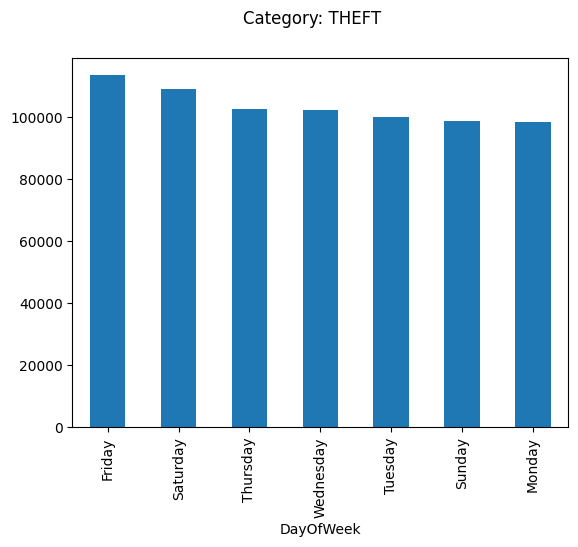

In [25]:

crime_df_tmp = crime_df[crime_df['CAT'] == 'THEFT']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: THEFT')
plt.show()

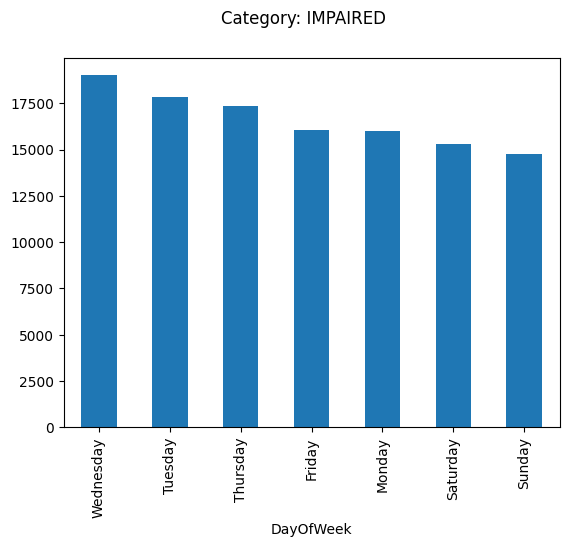

In [26]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: IMPAIRED')
plt.show()

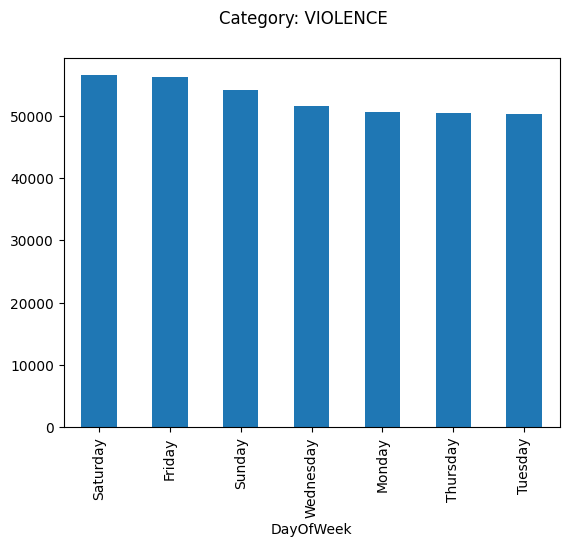

In [27]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: VIOLENCE')
plt.show()

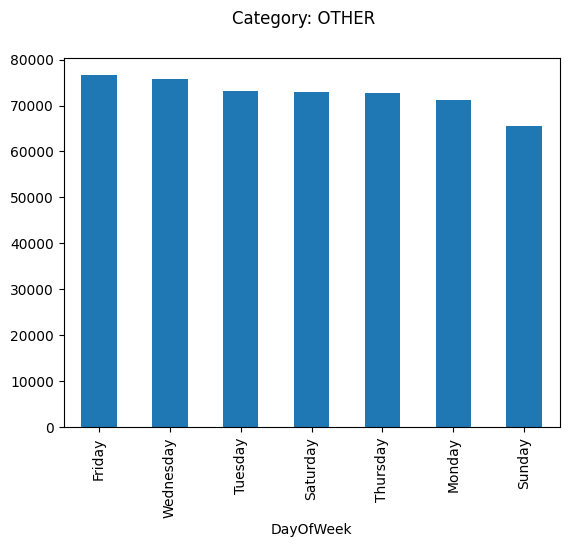

In [28]:
crime_df_tmp = crime_df[crime_df['CAT'] == 'OTHER']
crime_df_tmp['DayOfWeek'].value_counts().plot(kind='bar')
plt.suptitle('Category: OTHER')
plt.show()

# Feature Engineering

### Day of month

In [29]:
crime_df.loc[:, "Day_of_month"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[1]) if pd.notnull(dte) else None)

/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/3120289204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df.loc[:, "Day_of_month"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[1]) if pd.notnull(dte) else None)


In [69]:
### Month of year

In [30]:
crime_df.loc[:, "Month_of_year"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[0]) if pd.notnull(dte) else None)
crime_by_month = pd.DataFrame(crime_df["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
crime_by_month.index.name = 'Month_of_year'
crime_by_month.reset_index(inplace=True)

crime_by_month['Month_of_year'] = crime_by_month['Month_of_year'].astype(int)

crime_by_month

/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/655778281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df.loc[:, "Month_of_year"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[0]) if pd.notnull(dte) else None)


,Month_of_year,count
0,1,152031
1,2,137240
2,3,152198
3,4,146785
4,5,145321
5,6,136140
6,7,142551
7,8,146567
8,9,142686
9,10,148015


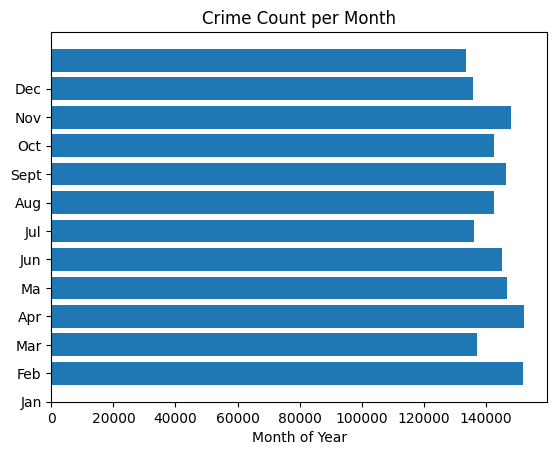

In [31]:
# Create a bar plot
plt.barh(crime_by_month['Month_of_year'], crime_by_month['count'],align='center', alpha=1)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)

# Set labels and title
plt.xlabel('Month of Year')
plt.title('Crime Count per Month')

# Show the plot
plt.show()


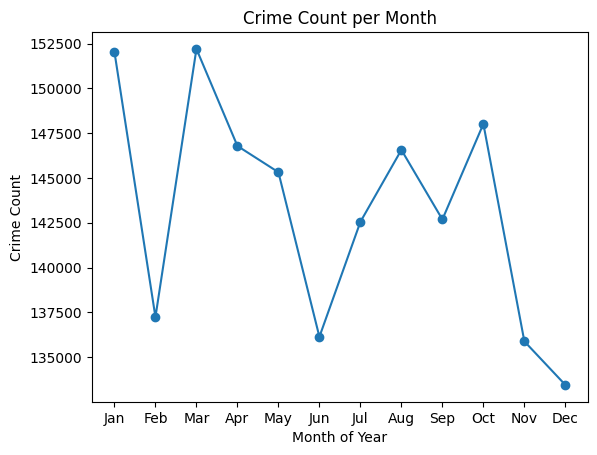

In [32]:
plt.plot(crime_by_month['Month_of_year'], crime_by_month['count'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Month of Year')
plt.ylabel('Crime Count')
plt.title('Crime Count per Month')

months = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xticks(crime_by_month['Month_of_year'], months)

# Show the plot
plt.show()

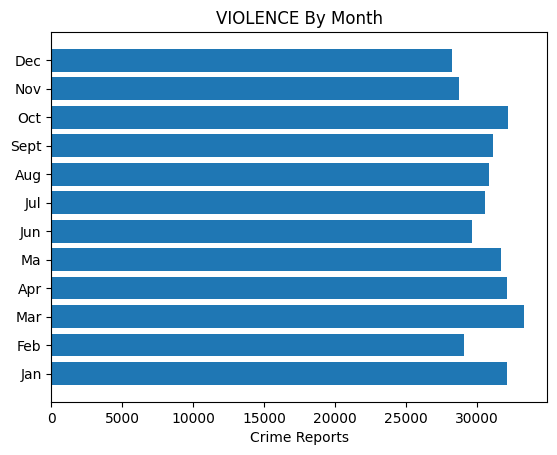

In [33]:
crime_by_month = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
crime_by_month.index.name = 'Month_of_year'
crime_by_month.reset_index(inplace=True)
plt.barh(crime_by_month.index, crime_by_month['count'],align='center', alpha=1)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Month')
plt.show()

 

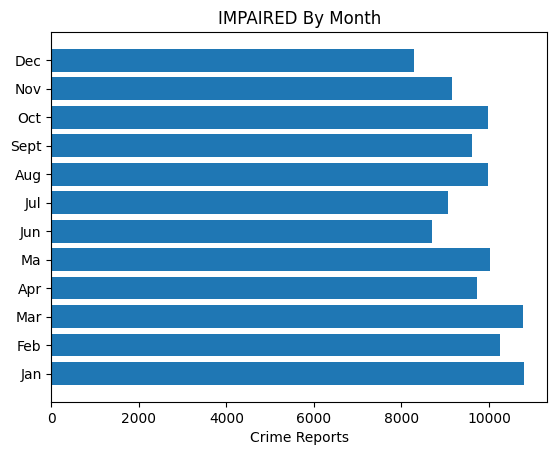

In [34]:
crime_by_month = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
crime_by_month.index.name = 'Month_of_year'
crime_by_month.reset_index(inplace=True)
plt.barh(crime_by_month.index, crime_by_month['count'], align='center', alpha=1)
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Month')
plt.show()


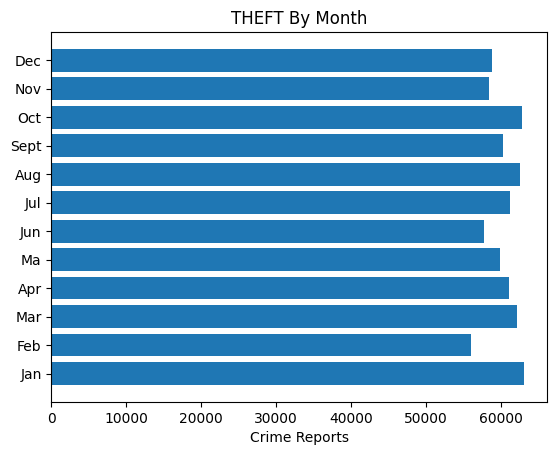

In [35]:
crime_by_month = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_month = pd.DataFrame(crime_by_month["Month_of_year"].value_counts())
crime_by_month = crime_by_month.sort_index()
crime_by_month.index.name = 'Month_of_year'
crime_by_month.reset_index(inplace=True)
plt.barh(crime_by_month.index, crime_by_month['count'])
objects = ['Jan','Feb','Mar','Apr','Ma','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.yticks(crime_by_month.index, objects)
plt.xlabel('Crime Reports')
plt.title('THEFT By Month')
plt.show()

# Year

In [36]:
crime_df.loc[:, "Year"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[2]) if pd.notnull(dte) else None)

/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/1923147236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df.loc[:, "Year"] = crime_df['Date'].apply(lambda dte: int(dte.split("/")[2]) if pd.notnull(dte) else None)


In [37]:
crime_by_year = pd.DataFrame(crime_df['Year'].value_counts())
crime_by_year = crime_by_year.sort_index()
crime_by_year.index.name = 'Year'
crime_by_year.reset_index(inplace=True)

crime_by_year

,Year,count
0,2003,109694
1,2004,109443
2,2005,107602
3,2006,108049
4,2007,105467
5,2008,109584
6,2009,107760
7,2010,101935
8,2011,101731
9,2012,110408


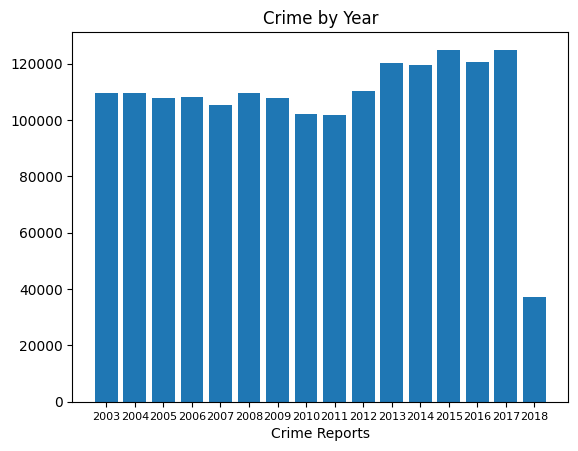

In [38]:
plt.bar(crime_by_year['Year'], crime_by_year['count'])
plt.xticks(crime_by_year['Year'],fontsize = 8)
plt.xlabel('Crime Reports')
plt.title('Crime by Year')
plt.show()

### Day Of The Week

In [39]:
# Transform day of week into ordered numbers 
selections = [
    (crime_df['DayOfWeek']=='Monday'),
    (crime_df['DayOfWeek']=='Tuesday'),
    (crime_df['DayOfWeek']=='Wednesday'),
    (crime_df['DayOfWeek']=='Thursday'),
    (crime_df['DayOfWeek']=='Friday'),
    (crime_df['DayOfWeek']=='Saturday'),
    (crime_df['DayOfWeek']=='Sunday')] 

new_categories = [1,2,3,4,5,6,7]
crime_df['Day_of_week'] = np.select(selections, new_categories, default=7)
 
crime_by_day = pd.DataFrame(crime_df["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index()
crime_by_day

/var/folders/sq/_5y2ywcj7cg5337ll7srmzd00000gn/T/ipykernel_5445/1384240911.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['Day_of_week'] = np.select(selections, new_categories, default=7)


,count
Day_of_week,
1,236391
2,241280
3,248557
4,243131
5,262387
6,253992
7,233138


In [40]:
crime_by_day = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index()
crime_by_day

,count
Day_of_week,
1,50581
2,50288
3,51555
4,50458
5,56205
6,56512
7,54178


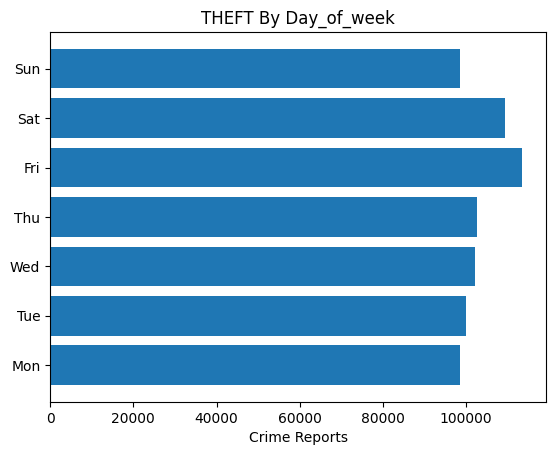

In [41]:
crime_by_day = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 
crime_by_day.reset_index(inplace=True)

plt.barh(crime_by_day['Day_of_week'], crime_by_day['count'], align='center')
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day['Day_of_week'], objects)
plt.xlabel('Crime Reports')
plt.title('THEFT By Day_of_week')
plt.show()

 


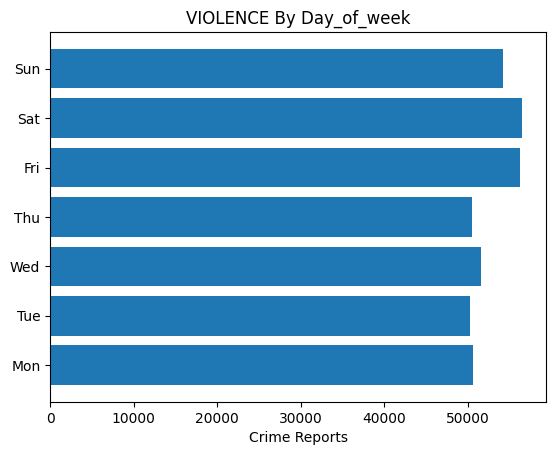

In [42]:
crime_by_day = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 
crime_by_day.reset_index(inplace=True)

plt.barh(crime_by_day['Day_of_week'], crime_by_day['count'], align='center')
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day['Day_of_week'], objects)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Day_of_week')
plt.show()


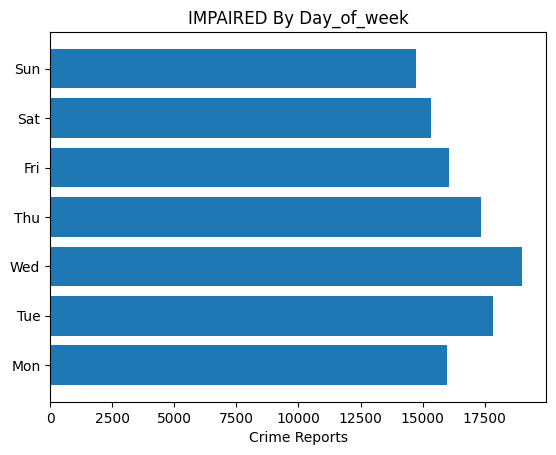

In [43]:
crime_by_day = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_day = pd.DataFrame(crime_by_day["Day_of_week"].value_counts())
crime_by_day = crime_by_day.sort_index() 
crime_by_day.reset_index(inplace=True)

plt.barh(crime_by_day['Day_of_week'], crime_by_day['count'], align='center')
objects = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(crime_by_day['Day_of_week'], objects)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Day_of_week')
plt.show()

In [44]:
crime_by_month["Month_of_year"]

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
Name: Month_of_year, dtype: int64

# Geo coordinates 

In [45]:
crime_df["Longitude"].describe()

count    1.718876e+06
mean    -1.224230e+02
std      2.976077e-02
min     -1.225136e+02
25%     -1.224334e+02
50%     -1.224167e+02
75%     -1.224067e+02
max     -1.205000e+02
Name: Longitude, dtype: float64

In [46]:
crime_df["Latitude"].describe()

count    1.718876e+06
mean     3.777159e+01
std      4.166044e-01
min      3.770788e+01
25%      3.775440e+01
50%      3.777542e+01
75%      3.778491e+01
max      9.000000e+01
Name: Latitude, dtype: float64

### Remove Geo-coords Outliers

In [47]:
# plot geocords
# remove edge coordinates / outliers 
q = crime_df["Longitude"].quantile(0.95)
crime_df = crime_df[crime_df["Longitude"] < q]
q = crime_df["Latitude"].quantile(0.95)
crime_df = crime_df[crime_df["Latitude"] < q]
crime_df["Latitude"].describe()

count    1.551062e+06
mean     3.776763e+01
std      2.240162e-02
min      3.770788e+01
25%      3.775631e+01
50%      3.777542e+01
75%      3.778414e+01
max      3.779964e+01
Name: Latitude, dtype: float64

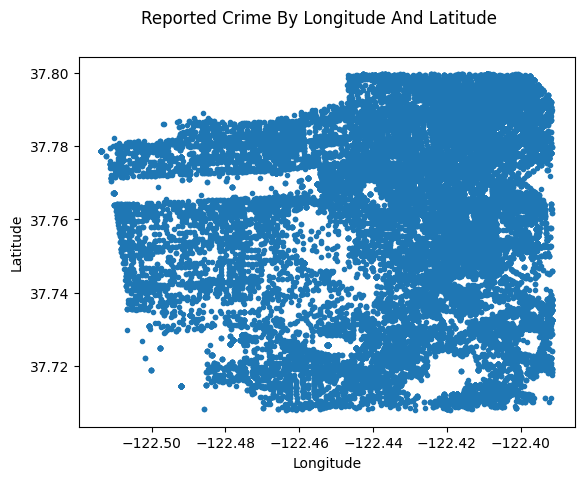

In [48]:
plt.plot(crime_df['Longitude'].head(50000), 
         crime_df['Latitude'].head(50000),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime By Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

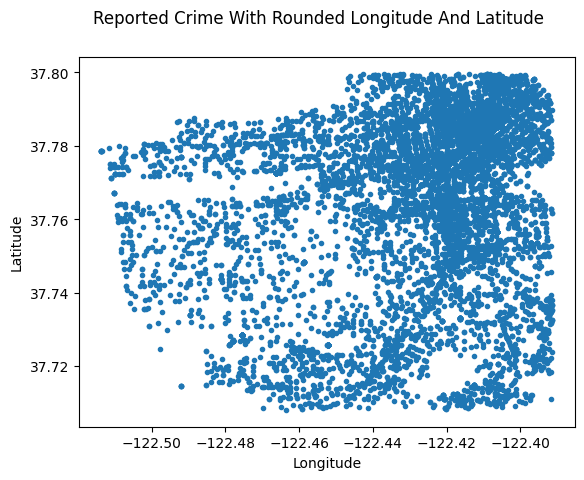

In [49]:
rounding_factor = 4
plt.plot(np.round(crime_df['Longitude'].head(10000),rounding_factor), 
         np.round(crime_df['Latitude'].head(10000),rounding_factor),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime With Rounded Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

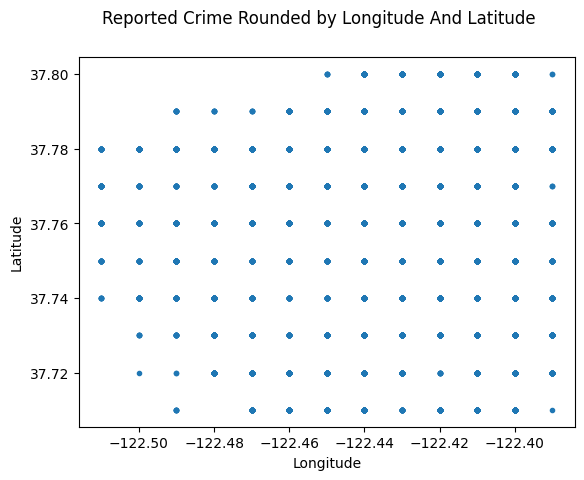

In [50]:
rounding_factor = 2
plt.plot(np.round(crime_df['Longitude'].head(10000),rounding_factor), 
         np.round(crime_df['Latitude'].head(10000),rounding_factor),
         linestyle='none', marker='.')
plt.suptitle('Reported Crime Rounded by Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Create heatmap


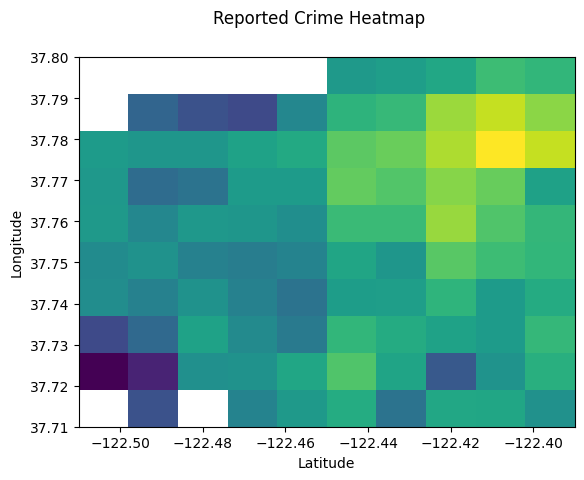

In [51]:
# Create heatmap
from matplotlib.colors import LogNorm
x = np.round(crime_df['Longitude'].head(10000),rounding_factor)
y = np.round(crime_df['Latitude'].head(10000),rounding_factor)
fig = plt.figure()
plt.suptitle('Reported Crime Heatmap')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
H, xedges, yedges, img = plt.hist2d(x, y, norm=LogNorm())
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]

plt.show()

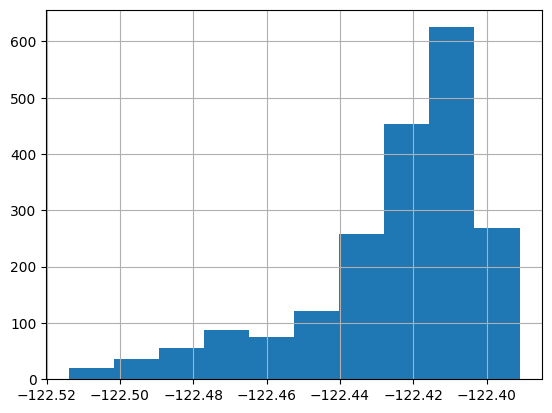

In [52]:
crime_df['Longitude'] = np.round(crime_df['Longitude'],3)
crime_df['Latitude'] = np.round(crime_df['Latitude'],3)
crime_df['Longitude'].head(2000).hist()
plt.show()

# Time Segments

### Create AM, AFT, NT

In [53]:
# create AM, AFT, NT
crime_df["Hour"] = [int(hr.split(":")[0]) for hr in crime_df['Time']]
crime_df["Hour"]

# create new super groups
selections = [
    (crime_df['Hour'] > 5) & (crime_df['Hour'] <=13),
    (crime_df['Hour']  > 13) & (crime_df['Hour'] <= 19),
    (crime_df['Hour']  > 18) & (crime_df['Hour'] <= 5)] 

new_categories = [0, 1, 2] # ['AM', 'AFT', 'NIT']
time_segment_names = ['AM','AFT','NIT']
crime_df['Day_Segment'] = np.select(selections, new_categories, default=2)
crime_df['Day_Segment'].value_counts()


Day_Segment
2    543461
1    530982
0    476619
Name: count, dtype: int64

In [54]:
crime_df.head()

,Category,DayOfWeek,Date,Time,Longitude,Latitude,CAT,Day_of_month,Month_of_year,Year,Day_of_week,Hour,Day_Segment
0,ROBBERY,Monday,11/22/2004,17:50,-122.420,37.708,THEFT,22,11,2004,1,17,1
4,ASSAULT,Sunday,11/21/2010,17:00,-122.411,37.771,VIOLENCE,21,11,2010,7,17,1
5,ASSAULT,Tuesday,04/02/2013,15:50,-122.470,37.745,VIOLENCE,2,4,2013,2,15,1
6,ASSAULT,Sunday,08/06/2017,18:15,-122.403,37.775,VIOLENCE,6,8,2017,7,18,1
7,VEHICLE THEFT,Thursday,03/03/2016,19:30,-122.464,37.708,THEFT,3,3,2016,4,19,1


## Plot time segments by crime

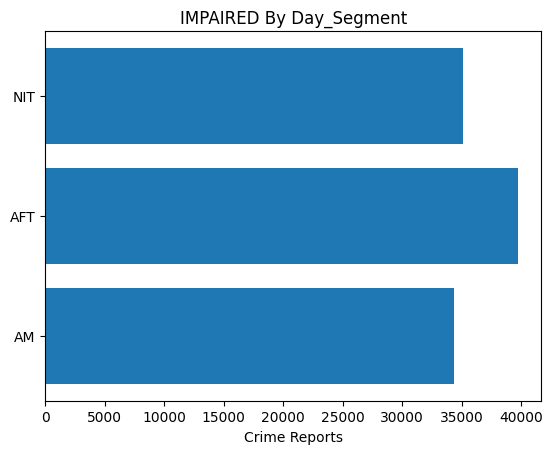

In [55]:
crime_by_time = crime_df[crime_df['CAT'] == 'IMPAIRED']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 
crime_by_time.reset_index(inplace=True)

plt.barh(crime_by_time['Day_Segment'], crime_by_time["count"], align='center')
plt.yticks(crime_by_time['Day_Segment'], time_segment_names)
plt.xlabel('Crime Reports')
plt.title('IMPAIRED By Day_Segment')
plt.show()

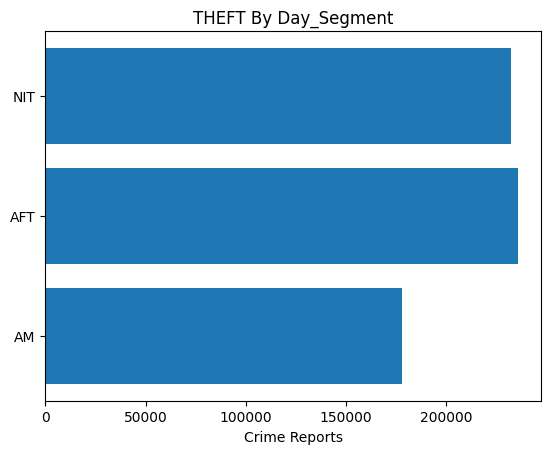

In [56]:
crime_by_time = crime_df[crime_df['CAT'] == 'THEFT']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 
crime_by_time.reset_index(inplace=True)

plt.barh(crime_by_time['Day_Segment'], crime_by_time["count"], align='center')
plt.yticks(crime_by_time['Day_Segment'], time_segment_names)
plt.xlabel('Crime Reports')
plt.title('THEFT By Day_Segment')
plt.show()

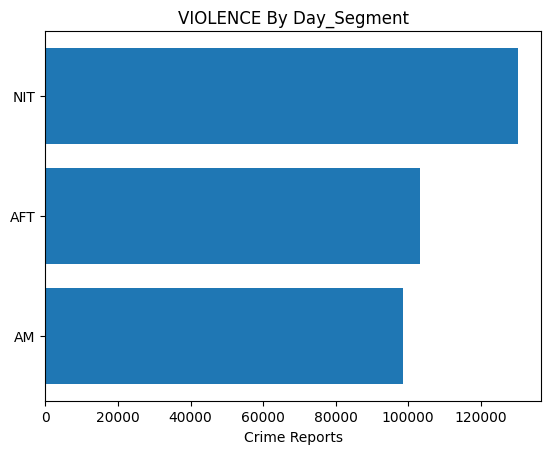

In [57]:
crime_by_time = crime_df[crime_df['CAT'] == 'VIOLENCE']
crime_by_time = pd.DataFrame(crime_by_time["Day_Segment"].value_counts())
crime_by_time = crime_by_time.sort_index() 
crime_by_time.reset_index(inplace=True)

plt.barh(crime_by_time['Day_Segment'], crime_by_time["count"], align='center')
plt.yticks(crime_by_time['Day_Segment'], time_segment_names)
plt.xlabel('Crime Reports')
plt.title('VIOLENCE By Day_Segment')
plt.show()

# Final features for model

In [58]:
crime_df = crime_df[['CAT', 'Day_of_month','Month_of_year', 'Day_Segment', 'Longitude', 'Latitude', 'Year']]

In [59]:
crime_df.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year
0,THEFT,22,11,1,-122.420,37.708,2004
4,VIOLENCE,21,11,1,-122.411,37.771,2010
5,VIOLENCE,2,4,1,-122.470,37.745,2013
6,VIOLENCE,6,8,1,-122.403,37.775,2017
7,THEFT,3,3,1,-122.464,37.708,2016


# Creating Crime Estimates 

## Aggregating data down to time and location

In [60]:
# aggregate data with groupby
crime_df.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year
0,THEFT,22,11,1,-122.420,37.708,2004
4,VIOLENCE,21,11,1,-122.411,37.771,2010
5,VIOLENCE,2,4,1,-122.470,37.745,2013
6,VIOLENCE,6,8,1,-122.403,37.775,2017
7,THEFT,3,3,1,-122.464,37.708,2016


In [61]:
list(crime_df)

['CAT',
 'Day_of_month',
 'Month_of_year',
 'Day_Segment',
 'Longitude',
 'Latitude',
 'Year']

In [62]:
crime_df['Count'] = 0

In [70]:
crime_df_agg = crime_df.groupby(['CAT', 'Day_of_month', 'Month_of_year',  'Day_Segment', 
                                 'Longitude',  'Latitude',]).count().reset_index()

crime_df_agg.to_csv('sf-crime-horizon.csv', index=None)


In [71]:
crime_df_agg.tail()
 

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year,Count
1245391,VIOLENCE,31,12,2,-122.392,37.730,1,1
1245392,VIOLENCE,31,12,2,-122.392,37.732,1,1
1245393,VIOLENCE,31,12,2,-122.392,37.758,1,1
1245394,VIOLENCE,31,12,2,-122.392,37.789,1,1
1245395,VIOLENCE,31,12,2,-122.391,37.719,1,1


# Reconstructing Crime Maps By Time Signature
This is the part where we throw in a date, and see what it returns. We'll use a similar concept in the web application but it will be controlled by a slider. 



In [72]:
Day_of_month = 1
Month_of_year = 1
Day_Segment = 2
crime_df_agg_tmp = crime_df_agg[(crime_df_agg['Day_of_month'] == Day_of_month) &
                               (crime_df_agg['Month_of_year'] == Month_of_year) &
                                 (crime_df_agg['Day_Segment'] == Day_Segment)]
crime_df_agg_tmp.head()

,CAT,Day_of_month,Month_of_year,Day_Segment,Longitude,Latitude,Year,Count
140,IMPAIRED,1,1,2,-122.503,37.760,1,1
141,IMPAIRED,1,1,2,-122.494,37.738,1,1
142,IMPAIRED,1,1,2,-122.492,37.714,1,1
143,IMPAIRED,1,1,2,-122.492,37.742,2,2
144,IMPAIRED,1,1,2,-122.489,37.761,1,1


In [74]:
import datetime
monthinteger = Month_of_year
Month_Name = datetime.date(1900, monthinteger, 1).strftime('%B')
    

# translate time signature into readable format
title = "Crime Estimates For %s %s %s" % (Month_Name, Day_of_month, time_segment_names[Day_Segment])


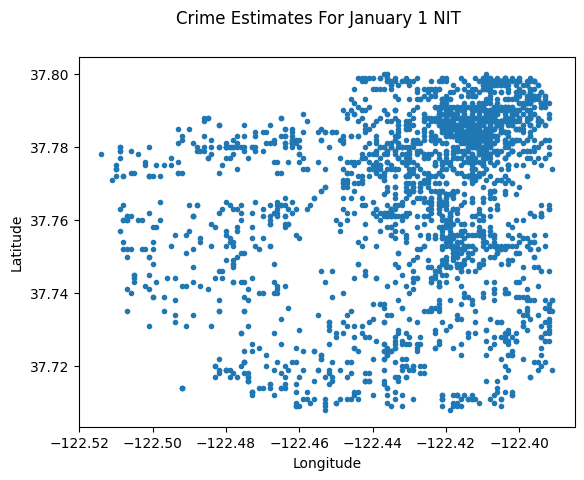

In [75]:
plt.plot(crime_df_agg_tmp['Longitude'] , 
         crime_df_agg_tmp['Latitude'] ,
         linestyle='none', marker='.')
plt.suptitle(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

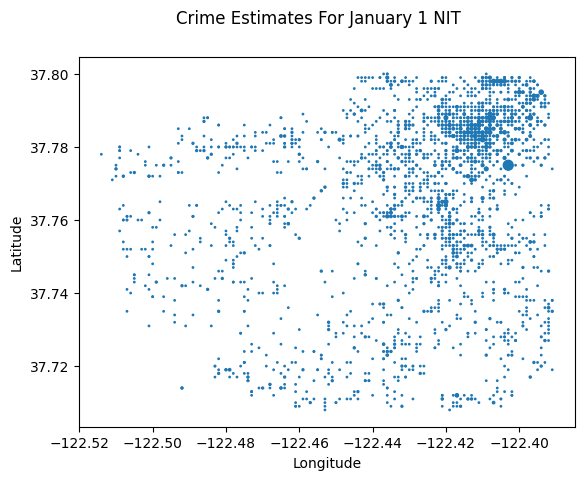

In [76]:
# Using plot.scatter to benefit from size of dot
plt.scatter(crime_df_agg_tmp['Longitude'] , 
         crime_df_agg_tmp['Latitude'] , s=crime_df_agg_tmp['Count'])
plt.suptitle(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Creating crime points for Google Maps

In [77]:
crime_df_agg_tmp['Longitude'].head()

140   -122.503
141   -122.494
142   -122.492
143   -122.492
144   -122.489
Name: Longitude, dtype: float64

In [78]:
# create new Google maps LatLng string
# Google LatLng format: new google.maps.LatLng(37.770467, -122.409801), new google.maps.LatLng(37.770090, -122.408904),
LatLngString = ''
for index, row in crime_df_agg_tmp.iterrows():
    LatLngString += "new google.maps.LatLng(" + str(row['Latitude']) + "," + str(row['Longitude']) + "),"
     
     

## Abstracting Code Into A Function For Our Web Appliction

In [79]:
crime_horizon_df = pd.read_csv('sf-crime-horizon.csv')
 

def GetCrime(horizon_date, horizon_time_segment):
    Day_of_month = int(horizon_date.split('/')[1])
    print('Day_of_month:',Day_of_month)
    Month_of_year = int(horizon_date.split('/')[0])
    print('Month_of_year:',Month_of_year)
    Day_Segment = int(horizon_time_segment) # 0,1,2
    print('Day_Segment:',Day_Segment)
    crime_horizon_df_tmp = crime_horizon_df[(crime_horizon_df['Day_of_month'] == Day_of_month) &
                                   (crime_horizon_df['Month_of_year'] == Month_of_year) &
                                     (crime_horizon_df['Day_Segment'] == Day_Segment)]
    
    LatLngString = ''
    # build latlng string for google maps
    for index, row in crime_horizon_df_tmp.iterrows():
        LatLngString += "new google.maps.LatLng(" + str(row['Latitude']) + "," + str(row['Longitude']) + "),"
     
    return (LatLngString)
    
    
preds_crime_horizon = GetCrime('10/10/2018', 0)

Day_of_month: 10
Month_of_year: 10
Day_Segment: 0


In [80]:
preds_crime_horizon[0:1000]

'new google.maps.LatLng(37.764,-122.508),new google.maps.LatLng(37.781,-122.49),new google.maps.LatLng(37.711,-122.469),new google.maps.LatLng(37.764,-122.467),new google.maps.LatLng(37.748,-122.459),new google.maps.LatLng(37.769,-122.454),new google.maps.LatLng(37.772,-122.454),new google.maps.LatLng(37.768,-122.453),new google.maps.LatLng(37.769,-122.453),new google.maps.LatLng(37.724,-122.436),new google.maps.LatLng(37.76,-122.436),new google.maps.LatLng(37.783,-122.433),new google.maps.LatLng(37.78,-122.432),new google.maps.LatLng(37.735,-122.431),new google.maps.LatLng(37.761,-122.426),new google.maps.LatLng(37.765,-122.423),new google.maps.LatLng(37.766,-122.422),new google.maps.LatLng(37.79,-122.422),new google.maps.LatLng(37.765,-122.421),new google.maps.LatLng(37.763,-122.42),new google.maps.LatLng(37.764,-122.42),new google.maps.LatLng(37.753,-122.419),new google.maps.LatLng(37.773,-122.419),new google.maps.LatLng(37.775,-122.419),new google.maps.LatLng(37.788,-122.419),new g